In [11]:
 # Required package to load data 
import xarray as xr
import cdsapi
import os 
import datetime as dt
import warnings

# Required packages for ploting 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature.nightshade import Nightshade

import subprocess
import glob
import pandas as pd 
# In order to run the 'wget' command, wget needs to be available. 
# On a Windows machine, it is probably easiest to simply place the 'wget.exe' file 
# (see https://www.gnu.org/software/wget/) in the same directory as this Norebook

# plotting/mapmaknig/
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow

import numpy as np

In [173]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
data_folder = f'{home_path}\\Data'

In [174]:
outline = gpd.read_file(f"{gis_folder}\\hudson_basin.SHP",driver="SHP",crs="EPSG:26918")
for layer in [outline]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

In [14]:
# Define function to run wget command
def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

In [15]:
def run_download(url,verbose=False):
    cmd = 'wget -c --no-check-certificate -r -np -nH --user=daafip --password=Joyfully-Distant-Backer7' 
    cmd += ' -nd -R "*nd" ' # Only -nd relevant for METREF ### 15.nc, *30.nc, *45.nc
    cmd += url

    runcmd(cmd, verbose=verbose);

In [16]:
import datetime

In [17]:
datetime.datetime(2016, 1, 1)

datetime.datetime(2016, 1, 1, 0, 0)

In [18]:
day=10
url = f'https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/MSG/MDMET/NETCDF/2023/03/{day}/'

In [19]:
run_download(url,verbose=False)

In [20]:
files = glob.glob("*.nc")
ds = xr.open_dataset(files[0])

In [21]:
ds.sel(lat=slice(-75,-70),lon=slice(40,50))

<xarray.Dataset>
Dimensions:                 (time: 1, lat: 0, lon: 201)
Coordinates:
  * lat                     (lat) float32 
  * lon                     (lon) float32 40.0 40.05 40.1 ... 49.9 49.95 50.0
  * time                    (time) datetime64[ns] 2023-03-10
Data variables:
    ET                      (time, lat, lon) float64 ...
    crs                     |S1 ...
    max_nslots_missing      (time, lat, lon) float64 ...
    missing_values_percent  (time, lat, lon) float64 ...
Attributes: (12/27)
    date_created:               2023-03-11T00:28:54Z
    algorithm_version:          2.0.0
    base_algorithm_version:     0.5.4
    processing_level:           04
    platform:                   MSG4
    sensor:                     SEVI
    ...                         ...
    westernmost_longitude:      80.0
    spatial_resolution:          0.05x 0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    Conventions:                CF-1.6
    netcdf_version_id:          netCDF4

<GeoAxesSubplot: title={'center': 'time = 2023-03-10'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

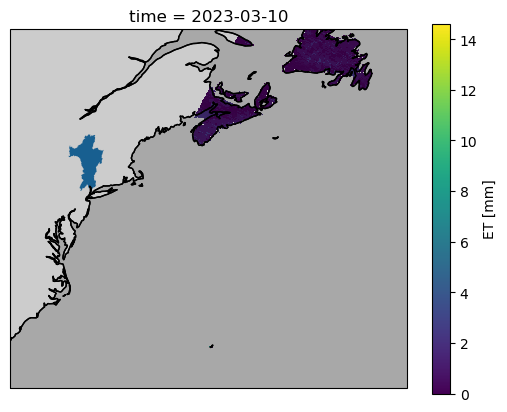

In [22]:
# to avoid showing warnings of cartopy
import warnings
warnings.filterwarnings('ignore')

slot=dt.datetime(2023,3,29,0,0)
# slot = lst_xr[3]
pvar = ds.ET.isel(time=0)
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 
ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest')
ax.coastlines()
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
ax.add_feature(Nightshade(slot, alpha=0.2))
# ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.75, draw_labels=False)
ax.set_xlim((-80,-50))
ax.set_ylim((30,50))
outline.plot(ax=ax)

clearly falls outside our area

Not what we want, possibly evaporation? 

In [23]:
def evaporation(area, df, index):
    """
        takes an index and computes the volume water evaorated per day using given df
        Note precipitation has negligible salts, so ignored. 
    """
    LAMBDA = 2.45 * 10**6                           # MJ/kg
    RHO_AIR = 1.205                                 # density of air (kg/m3)
    RHO_W = 1000                                    # density of water (kg/m3)
    GAMMA = 0.066                                   # psychrometer constant (kPa/C) 
    C_P = 1004                                      # specifc heat of air at constant pressure (J/kg/K)
    
    u = df.loc[index, "wind_speed"]                 # m/s
    t = df.loc[index, "temperature"]                # deg
    rnet = df.loc[index, "rnet"] * 3600 * 24        # w/m^2 to: net radiation on the earth's surface (J/d/m^2): 1W = J/s
    RH =  df.loc[index, "RH"]/100                   # Relative humidity in %   
    
#     RH = 0.75
#     t = 20
#     u = 10.5
#     rnet = 20*10**6
    
    es = 0.61 * np.exp(19.9 * t /(t + 273.15))      # KPA
    ea = es * RH                                    # KPA
    s = ((5430 * es) / ((t + 273.15)**2))           # slope of the saturation vapour pressure-temperature curve (kPa/C)
    r_a = 245/(0.54 * u + 0.5)/86400
    
    numer =  ((s * rnet) / (RHO_W * LAMBDA)) + ((C_P * RHO_AIR * (es - ea))/(RHO_W * LAMBDA * r_a))
    denom = s + GAMMA
    E_p = numer / denom  # m/d
#     print(E_p)
    volume = E_p * area 
                                                
    return volume # m^3

### Try era5 data:

### automatic dowload with api

In [24]:
year0 = ["2011",
        "2012",
        "2013",
        "2014",
        "2015",
        "2016",
        "2017",
        "2018",
        "2019",
        "2020",
        "2021",
        "2022",
        "2023"]

In [25]:
year = datetime.timedelta(365)
years = []
prev_year_start = 2021

for i in range(7): # 70 years back
    prev_year = prev_year_start
    lst_years = []
    for i in range(10):
        next_year = datetime.datetime(prev_year,1,1) - year
        lst_years.append(str(next_year.year))
        prev_year = next_year.year
    
    years.append(lst_years[::-1])
    prev_year_start = next_year.year

In [26]:
# import logging
# logging.warning("request")
# logging.Handler(level=20)
print(years)

[['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'], ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010'], ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000'], ['1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990'], ['1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980'], ['1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970'], ['1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960']]


In [27]:
# for year in years:
#     get_era_5(year)

In [30]:
def get_era_5(year):
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': 'potential_evaporation',
            'year': year,
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                46, -76, 39,
                -70,
            ],
        },
        'download.nc')

In [32]:
get_era_5(year0)

2023-04-05 11:05:32,079 INFO Welcome to the CDS
2023-04-05 11:05:32,081 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-04-05 11:05:32,161 INFO Request is queued

KeyboardInterrupt



In [35]:
grib_files = glob.glob(f'{data_folder}\\EP\\*.grib')
grib_files

['C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\EP\\era5.grib']

In [38]:
ds = xr.load_dataset(grib_files[0],engine="cfgrib")

Can't read index file 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\EP\\era5.grib.923a8.idx'
Traceback (most recent call last):
  File "C:\Users\david\anaconda3\envs\SHIP\Lib\site-packages\cfgrib\messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\david\anaconda3\envs\SHIP\Lib\site-packages\cfgrib\messages.py", line 429, in from_indexpath
    index = pickle.load(file)
            ^^^^^^^^^^^^^^^^^
EOFError: Ran out of input


In [73]:
ds_daily = ds.sum(dim="step")
time = ds_daily.time.to_pandas()
time = pd.DataFrame(data=time, columns=["hour"])

In [110]:
timesplit = time.apply(lambda x: x.index.hour)
timesplit = timesplit.iloc[1:] # remove unwanted first value

In [111]:
index_18_00s = timesplit[timesplit.hour == 18]
index_06_00s = timesplit[timesplit.hour == 6]
index_18_00s["new_time"] = index_18_00s.apply(lambda x: x.index - datetime.timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=12, weeks=0))

In [112]:
ds_18 = ds_daily.sel(time=index_18_00s.index)
ds_18["time"] = index_18_00s.new_time.values
ds_18

<xarray.Dataset>
Dimensions:    (time: 4748, latitude: 21, longitude: 25)
Coordinates:
    number     int32 0
  * time       (time) datetime64[ns] 2010-01-01T06:00:00 ... 2022-12-31T06:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 45.0 44.75 44.5 44.25 ... 40.5 40.25 40.0
  * longitude  (longitude) float64 -76.0 -75.75 -75.5 ... -70.5 -70.25 -70.0
Data variables:
    pev        (time, latitude, longitude) float32 -1.881e-05 ... 1.187e-08

In [113]:
ds_16 = ds_daily.sel(time=index_06_00s.index)

In [123]:
ds_combined = ds_18 + ds_16

In [151]:
series_pev = ds_combined.mean(dim=["latitude","longitude"]).pev.to_pandas()
df_pev = pd.DataFrame(data=series_pev,columns=["Pev"])
df_pev.Pev = df_pev.Pev * - 1000

Text(0.5, 1.0, 'ERA5 evaporation')

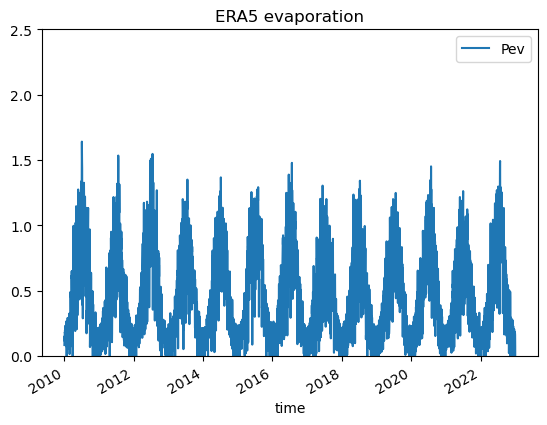

In [188]:
fig, ax = plt.subplots(1)
df_pev.plot(ax=ax)
ax.set_ylim(0,2.5)
ax.set_title("ERA5 evaporation")

In [183]:
ds_combined

<xarray.Dataset>
Dimensions:    (time: 4748, latitude: 21, longitude: 25)
Coordinates:
    number     int32 0
  * time       (time) datetime64[ns] 2010-01-01T06:00:00 ... 2022-12-31T06:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 45.0 44.75 44.5 44.25 ... 40.5 40.25 40.0
  * longitude  (longitude) float64 -76.0 -75.75 -75.5 ... -70.5 -70.25 -70.0
Data variables:
    pev        (time, latitude, longitude) float32 -5.348e-05 ... 7.497e-08

In [157]:
outline = gpd.read_file(f"{gis_folder}\\hudson_basin.SHP",driver="SHP",crs="EPSG:26918")

<GeoAxesSubplot: title={'center': 'number = 0 [1], time = 2010-01-01T06:00:00, sur...'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

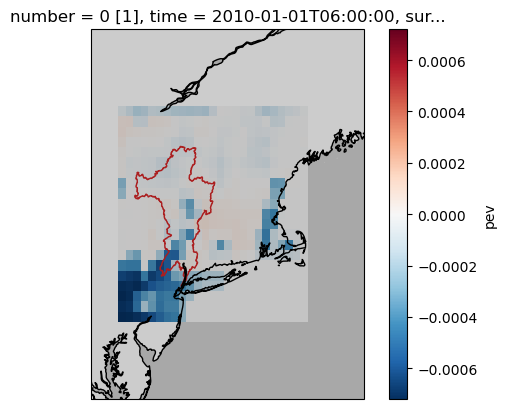

In [187]:
pvar = ds_combined.isel(time=0).pev
# ax = plt.axes(projection=ccrs.Orthographic(0, 0))  # to use the Orthographic projection 
ax = plt.axes(projection=ccrs.PlateCarree())      # to use simple lat/lon 
pvar.plot.imshow(ax=ax, transform=ccrs.PlateCarree(),interpolation='nearest')
ax.coastlines()
ax.add_feature(cfeature.OCEAN, facecolor='lightgray')
ax.add_feature(Nightshade(slot, alpha=0.2))
# ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.75, draw_labels=False)
ax.set_xlim((-77,-68))
ax.set_ylim((38,47))
outline.plot(ax=ax, edgecolor="C3", facecolor="None")